## Objetivo do projeto é:

1. Buscar termos específicos
2. Salvar resultados em um arquivo txt
3. Mostrar os resultados sobre as imagens dos termos específicos


### 1. Preparando o ambiente

In [3]:
%pip install opencv-python
!sudo apt install tesseract-ocr
%pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [37]:
!git clone https://gitlab.com/olooeez/text-recognize.git

Cloning into 'text-recognize'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 11 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (11/11), 786.56 KiB | 7.02 MiB/s, done.


In [5]:
import pytesseract
import numpy as np
import cv2
import re
import os
import matplotlib.pyplot as plt
from PIL import ImageFont, ImageDraw, Image
from pytesseract import Output
from google.colab.patches import cv2_imshow

In [8]:
!mkdir -p tessdata
!wget -O ./tessdata/por.traineddata https://github.com/tesseract-ocr/tessdata/blob/main/por.traineddata?raw=true -q
!wget -O ./tessdata/eng.traineddata https://github.com/tesseract-ocr/tessdata/blob/main/eng.traineddata?raw=true -q

### 2. Entendendo os dados

In [10]:
project_images = "/content/text-recognize/img"
project_images_path = [os.path.join(project_images, f) for f in os.listdir(project_images)]
project_images_path

['/content/text-recognize/img/artigo-spark.png',
 '/content/text-recognize/img/artigo-desbalanceamento.png',
 '/content/text-recognize/img/artigo-eng-dados.png',
 '/content/text-recognize/img/artigo-termos-ML.png']

In [16]:
def show(image):
  figure = plt.gcf()
  figure.set_size_inches(20, 10)
  plt.axis('off')
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.show()

In [ ]:
for image in project_images_path:
  image = cv2.imread(image)
  show(image)

In [18]:
config_tesseract = "--tessdata-dir tessdata"

def process_ocr(image, config_tesseract = config_tesseract):
  text = pytesseract.image_to_string(image, lang='por', config=config_tesseract)
  return text

### 2. Reconhecimento dos dados

In [19]:
complete_text = ''
text_output = 'resultado-ocr.txt'

In [22]:
for image_path in project_images_path:
  image = cv2.imread(image_path)
  image_name = str(os.path.split(image_path)[-1])
  complete_text += f"{image_name}\n"
  text = process_ocr(image)
  complete_text += text

In [23]:
complete_text

'artigo-spark.png\nTipos de processamento de dados\n\nNo contexto Big Data, o processamento de dados em batch (lote) é bastante conhecido\ndesde o surgimento do Hadoop. Devido aos seus recursos e robustez, o modelo de\nprogramação MapReduce do Hadoop tornou-se uma das principais estruturas de\nprocessamento de dados em batch. Com o passar do tempo boa parte dos desafios neste\ncampo foram bem solucionados e desde então a comunidade mudou sua atenção para outro\ndesafio, o processamento de dados em streaming.\n\nAlgumas pessoas já leram ou ouviram algo relacionado com a palavra streaming, por exemplo,\nao comentar sobre plataformas de transmissão de áudio e vídeo como Spotify, Amazon\nMusic, Youtube e Netflix ou aplicações mais específicas como sistemas de monitoramento de\nbolsas de valores ou aplicativos de coleta de dados enviados por sensores (loT). Mas, em um\ncenário de análise de dados, o que seria processamento de dados em streaming?\n\nO processamento de dados em batch executa 

### 3. Salvando os dados em documento .txt

In [24]:
txt_file = open(text_output, "w+")
txt_file.write(complete_text + "\n")
txt_file.close()

### 4. Busca de ocorrências

1. Nos textos
2. Na listagem de imagens

In [25]:
search_term = 'learning'

In [26]:
with open(text_output) as f:
  ocourrencies = [i.start() for i in re.finditer(search_term, f.read())]

In [27]:
ocourrencies

[1968, 4012, 6892]

In [29]:
for image_path in project_images_path:
  image = cv2.imread(image_path)
  image_name = os.path.split(image_path)[-1]
  text = process_ocr(image)
  ocourrencies = [i.start() for i in re.finditer(search_term, text)]
  print(ocourrencies)

### 5. Reconhecimento na imagem

In [38]:
font = "/content/text-recognize/fonts/calibri.ttf"

In [39]:
def write(text, x, y, image, font=font, color=(50, 50, 255), size=16):
  font = ImageFont.truetype(font, size)
  image_pill = Image.fromarray(image)
  draw = ImageDraw.Draw(image_pill)
  draw.text((x, y-size), text, font=font, fill=color)
  image = np.array(image_pill)

  return image

In [40]:
min_conf = 30 #@param { type:"slider", min:0, max:100 }

In [41]:
def border_box(i, result, image, color=(255, 100, 0)):
  x = result['left'][i]
  y = result['top'][i]
  w = result['width'][i]
  h = result['height'][i]

  cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)

  return x, y, image

In [42]:
def process_ocr(image, search_term, config_tesseract, min_conf):
  result = pytesseract.image_to_data(image, config=config_tesseract, lang='por', output_type=Output.DICT)
  num_ocourrencies = 0

  for i in range(0, len(result['text'])):
    confidence = int(result['conf'][i])

    if confidence > min_conf:
      text = result['text'][i]

      if search_term in text:
        x, y, image = border_box(i, result, image, (0, 0, 255))
        image = write(text, x, y, image, font, (50, 50, 255), 14)

        num_ocourrencies += 1

  return image, num_ocourrencies

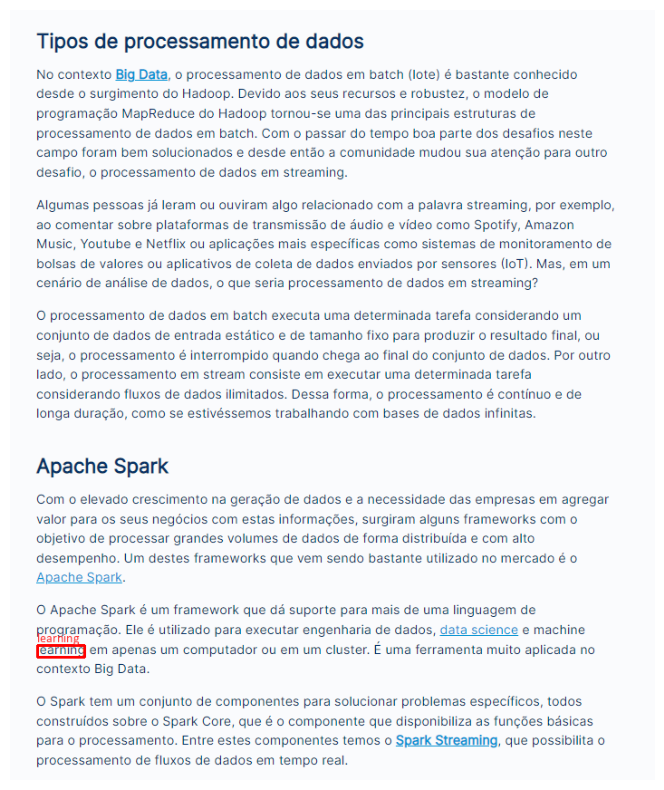

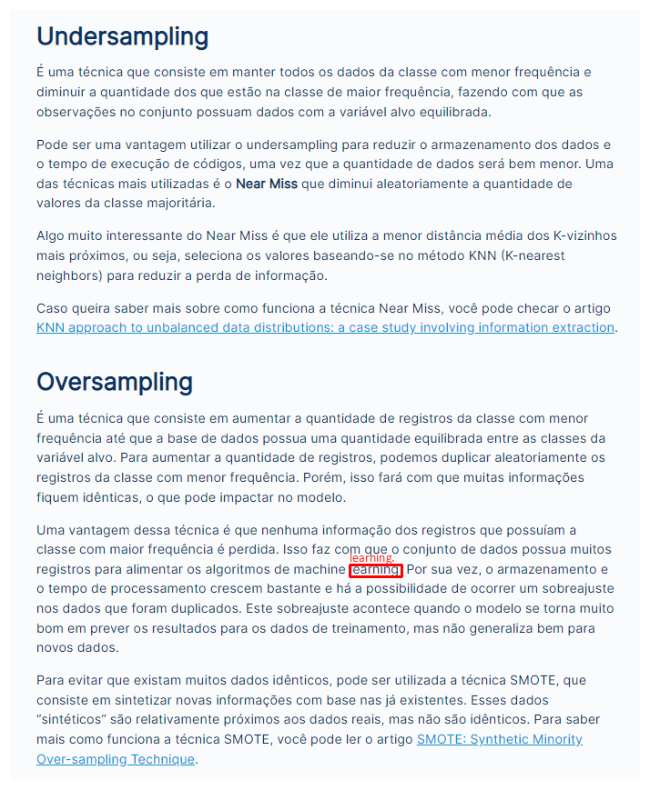

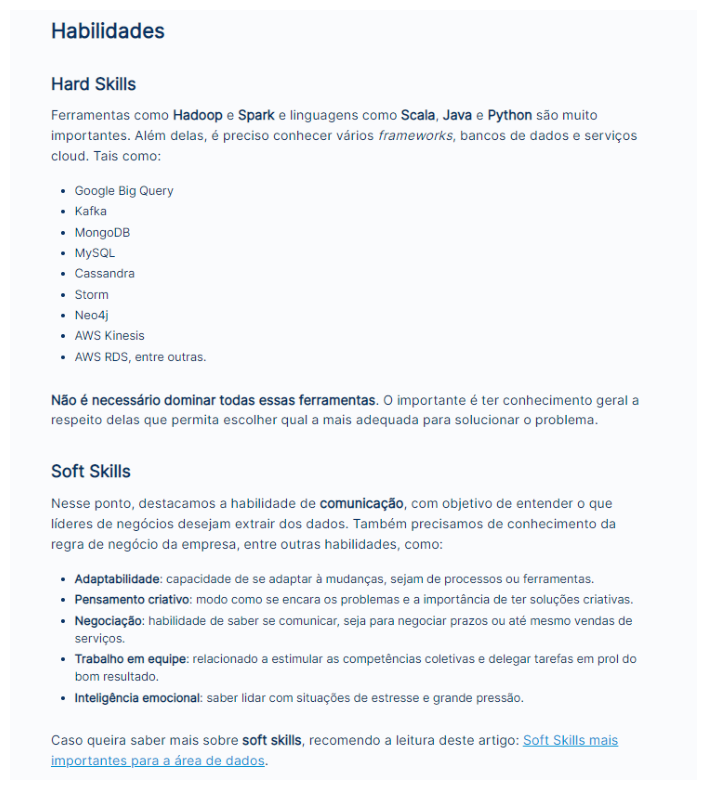

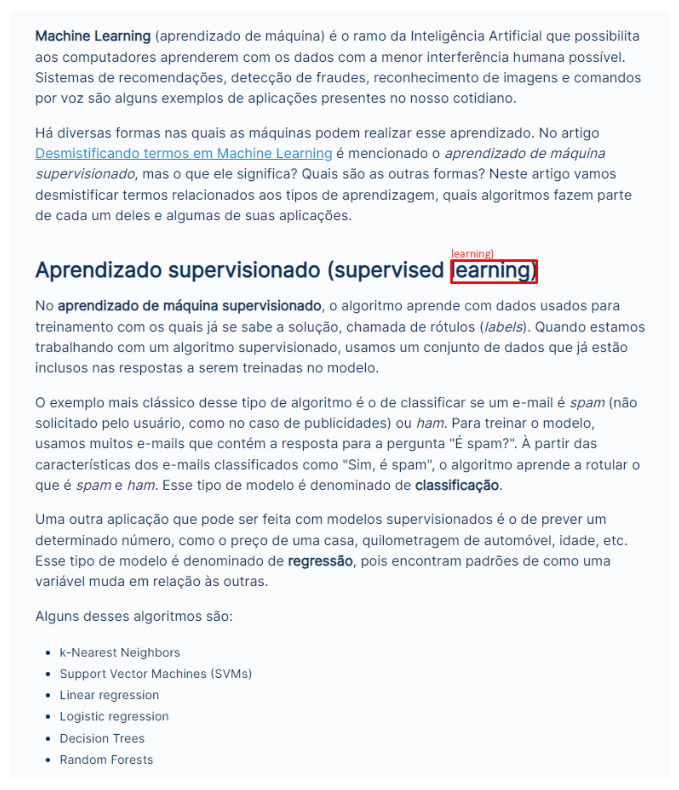

In [43]:
search_term = 'learning'

for image_path in project_images_path:
  image = cv2.imread(image_path)
  image_original = image.copy()
  image_name = os.path.split(image_path)[-1]

  image, num_ocourrencies = process_ocr(image, search_term, config_tesseract, min_conf)

  show(image)